# Imports

In [33]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
import numpy as np
import math
import tensorflow as tf
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation
import h5py
from keras.optimizers import Adamax, Nadam
import sys
import pickle
from writeNNet import saveNNet

from interval import interval, inf

from safe_train import propagate_interval, check_intervals, project_weights, plot_policy

import matplotlib.pyplot as plt

# Constants

In [39]:
ver = 4  # Neural network version
hu = 45  # Number of hidden units in each hidden layer in network
totalEpochs = 20  # Total number of training epochs
BATCH_SIZE = 2**8
EPOCH_TO_PROJECT = 1
trainingDataFiles = (
    "../TrainingData/VertCAS_TrainingData_v2_%02d.h5"  # File format for training data
)
nnetFiles = "../networks/ProjectionVertCAS_pra%02d_v%d_45HU_%03d.nnet"  # File format for .nnet files
COC_INTERVAL = [
    interval[400, 500],
    interval[50, 51],
    interval[-51, -50],
    interval[20, 21],
]
# COC high, SDES2500 low
desired_interval = [
    interval[7000, 15000],  # COC
    None,  # DNC
    None,  # DND
    None,  # DES1500
    None,  # CL1500
    None,  # SDES1500
    None,  # SCL1500
    interval[-2000, 6000],  # SDES2500
    None,  # SCL2500
]
advisories = {
    "COC": 0,
    "DNC": 1,
    "DND": 2,
    "DES1500": 3,
    "CL1500": 4,
    "SDES1500": 5,
    "SCL1500": 6,
    "SDES2500": 7,
    "SCL2500": 8,
}
pra = 1

# Constants for training, setup

In [40]:
print("Loading Data for VertCAS, pra %02d, Network Version %d" % (pra, ver))
f = h5py.File(trainingDataFiles % pra, "r")
X_train = np.array(f["X"])
Q = np.array(f["y"])
means = np.array(f["means"])
ranges = np.array(f["ranges"])
min_inputs = np.array(f["min_inputs"])
max_inputs = np.array(f["max_inputs"])
print(f"min inputs: {min_inputs}")
print(f"max inputs: {max_inputs}")

N, numOut = Q.shape
print(f"Setting up model with {numOut} outputs and {N} training examples")
num_batches = N / BATCH_SIZE

# Asymmetric loss function
lossFactor = 40.0

# NOTE(nskh): from HorizontalCAS which was updated to use TF
def asymMSE(y_true, y_pred):
    d = y_true - y_pred
    maxes = tf.argmax(y_true, axis=1)
    maxes_onehot = tf.one_hot(maxes, numOut)
    others_onehot = maxes_onehot - 1
    d_opt = d * maxes_onehot
    d_sub = d * others_onehot
    a = lossFactor * (numOut - 1) * (tf.square(d_opt) + tf.abs(d_opt))
    b = tf.square(d_opt)
    c = lossFactor * (tf.square(d_sub) + tf.abs(d_sub))
    d = tf.square(d_sub)
    loss = tf.where(d_sub > 0, c, d) + tf.where(d_opt > 0, a, b)
    return tf.reduce_mean(loss)

Loading Data for VertCAS, pra 01, Network Version 4
min inputs: [-8000.  -100.  -100.     0.]
max inputs: [8000.  100.  100.   40.]
Setting up model with 9 outputs and 4053465 training examples


# Define Model

In [41]:
# Define model architecture
model = Sequential()
model.add(Dense(hu, activation="relu", input_dim=4))
model.add(Dense(hu, activation="relu"))
model.add(Dense(hu, activation="relu"))
model.add(Dense(hu, activation="relu"))
model.add(Dense(hu, activation="relu"))
model.add(Dense(hu, activation="relu"))

# model.add(Dense(numOut, init="uniform"))
model.add(Dense(numOut))
opt = Nadam(learning_rate=0.0003)
model.compile(loss=asymMSE, optimizer=opt, metrics=["accuracy"])

# Train

on epoch 0
Policy viz before projectionh loss 0.09500999748706818 and accuracy 0.92562997341156012
 63/203 [========>.....................] - ETA: 0s

2023-07-06 23:50:20.545160: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


203/203 [==============================] - 1s 3ms/step


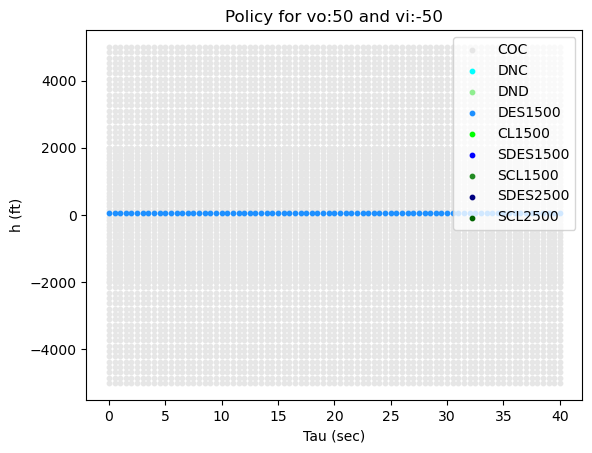

safe region test FAILED, interval was [interval([-38533.8845803125, 35658.818679234646]), interval([-59260.582553963955, 53530.02410253232]), interval([-50154.59427383241, 55732.94707701446]), interval([-52818.30682645143, 62998.43778835533]), interval([-46893.30302436604, 58519.57970567931]), interval([-42040.85529316537, 47393.38778838129]), interval([-48679.11471752943, 35868.576652855016]), interval([-40056.45605381905, 49588.40767335041]), interval([-52168.07194956515, 43436.44133288976])]

Projecting weights at epoch 0.
After projecting, output interval is [interval([6999.9990234375, 14394.725191183577]), interval([-59260.582553963955, 53530.02410253232]), interval([-50154.59427383241, 55732.94707701446]), interval([-52818.30682645143, 62998.43778835533]), interval([-46893.30302436604, 58519.57970567931]), interval([-42040.85529316537, 47393.38778838129]), interval([-48679.11471752943, 35868.576652855016]), interval([-1999.9999649165434, 5999.999860567123]), interval([-52168.0719

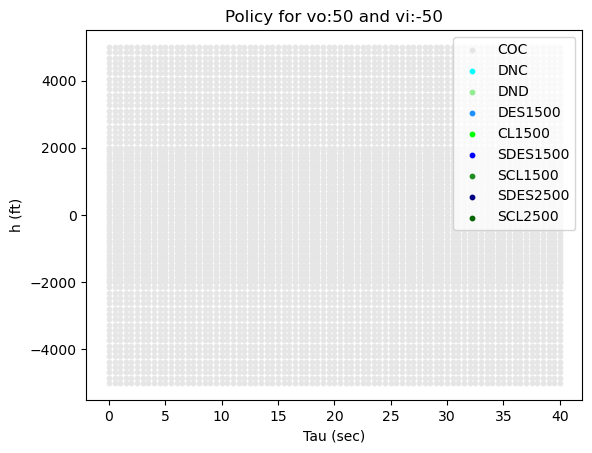

on epoch 1
Policy viz before projectionh loss 62.469200134277344 and accuracy 0.7955700159072876
203/203 [==============================] - 1s 3ms/step


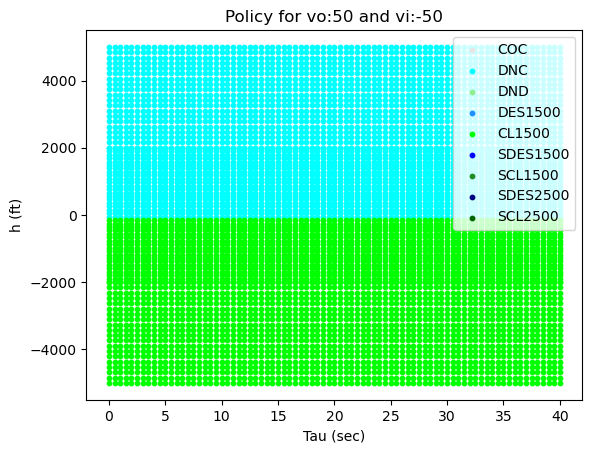

safe region test FAILED, interval was [interval([-1855753.164455876, -565437.1522718318]), interval([-1068509.29039244, 1140936.1178216566]), interval([-896305.9412583262, 859990.4721873126]), interval([-1029749.1880918668, 1127529.4850692041]), interval([-850209.8427310537, 927187.7040272558]), interval([-783601.4459089568, 833914.2909965299]), interval([-826530.3747683527, 796366.4298880427]), interval([-130517.62728775002, 120506.57264685821]), interval([-946647.7040679004, 975137.996028342])]

Projecting weights at epoch 1.
After projecting, output interval is [interval([6999.9979279365925, 13897.284356066466]), interval([-1068509.29039244, 1140936.1178216566]), interval([-896305.9412583262, 859990.4721873126]), interval([-1029749.1880918668, 1127529.4850692041]), interval([-850209.8427310537, 927187.7040272558]), interval([-783601.4459089568, 833914.2909965299]), interval([-826530.3747683527, 796366.4298880427]), interval([-2000.000027809775, 5999.999967887406]), interval([-946647

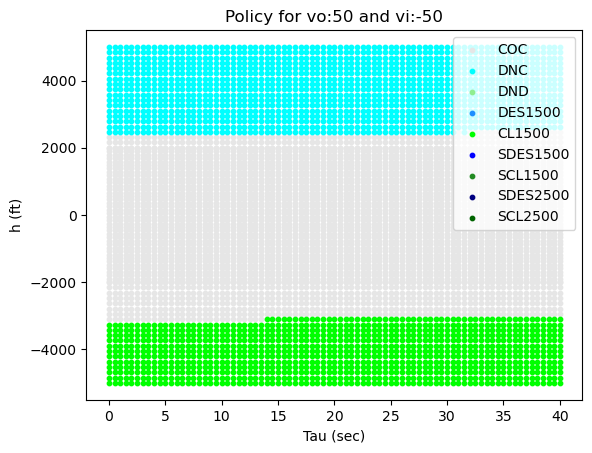

on epoch 2
Policy viz before projectionh loss 80.1141586303711 and accuracy 0.690039992332458568
203/203 [==============================] - 1s 3ms/step


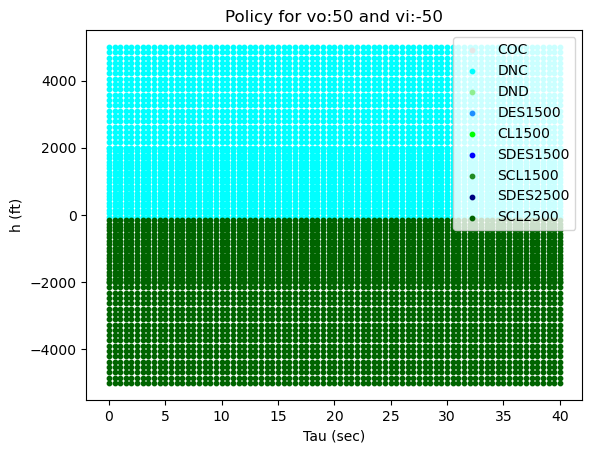

safe region test FAILED, interval was [interval([-1404882.5438775872, -764976.8974867953]), interval([-1497680.1925136133, 1492030.788100587]), interval([-1204864.2342774095, 1172459.8630056386]), interval([-1443444.1346768802, 1492912.9500404906]), interval([-1206917.9468813685, 1220669.0085894363]), interval([-1127034.5294400963, 1092965.2952214056]), interval([-1151140.335551262, 1079121.1401109367]), interval([-1986.9936155533157, -984.3028292352955]), interval([-1344795.3342912034, 1326617.6647690176])]

Projecting weights at epoch 2.
After projecting, output interval is [interval([6999.981532367731, 9690.339859727199]), interval([-1497680.1925136133, 1492030.788100587]), interval([-1204864.2342774095, 1172459.8630056386]), interval([-1443444.1346768802, 1492912.9500404906]), interval([-1206917.9468813685, 1220669.0085894363]), interval([-1127034.5294400963, 1092965.2952214056]), interval([-1151140.335551262, 1079121.1401109367]), interval([-1986.9936155533157, -984.3028292352955]

/Users/nishant/miniforge3/envs/mlp/lib/python3.10/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


203/203 [==============================] - 1s 2ms/step


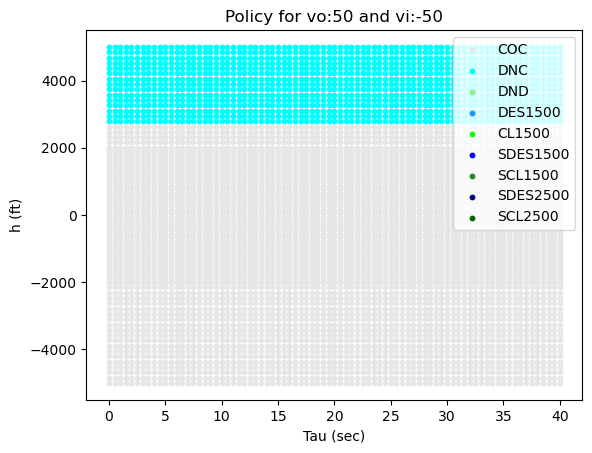

on epoch 3
Policy viz before projectionh loss 516.5193481445312 and accuracy 0.60237002372741717
203/203 [==============================] - 1s 3ms/step


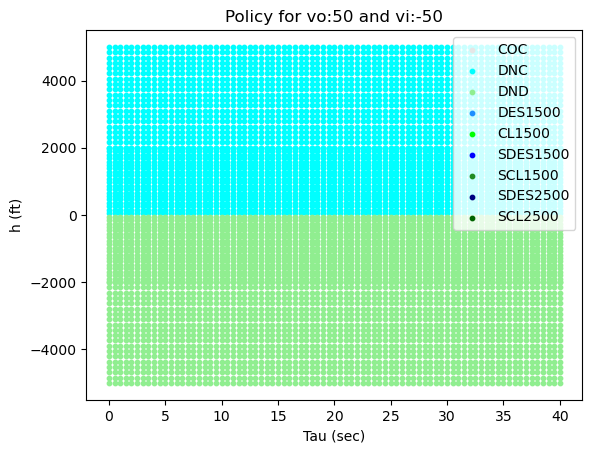

safe region test FAILED, interval was [interval([-1330864.115547191, -789563.2242777084]), interval([-1841516.957564597, 1840026.3154139493]), interval([-1479470.4132620357, 1444418.5289206752]), interval([-1774080.3214401298, 1833231.46265692]), interval([-1492880.7424720537, 1489707.2539449693]), interval([-1396429.7391554306, 1339964.2981796453]), interval([-1419256.8701329965, 1329107.2839416084]), interval([-5409.5171303220695, -3251.5557049030185]), interval([-1663288.8902481308, 1632419.629665514])]

Projecting weights at epoch 3.
After projecting, output interval is [interval([6999.972095254148, 9716.28079156066]), interval([-1841516.957564597, 1840026.3154139493]), interval([-1479470.4132620357, 1444418.5289206752]), interval([-1774080.3214401298, 1833231.46265692]), interval([-1492880.7424720537, 1489707.2539449693]), interval([-1396429.7391554306, 1339964.2981796453]), interval([-1419256.8701329965, 1329107.2839416084]), interval([-1999.9998827272266, -1150.4083361854373]), 

/Users/nishant/miniforge3/envs/mlp/lib/python3.10/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


203/203 [==============================] - 1s 3ms/step


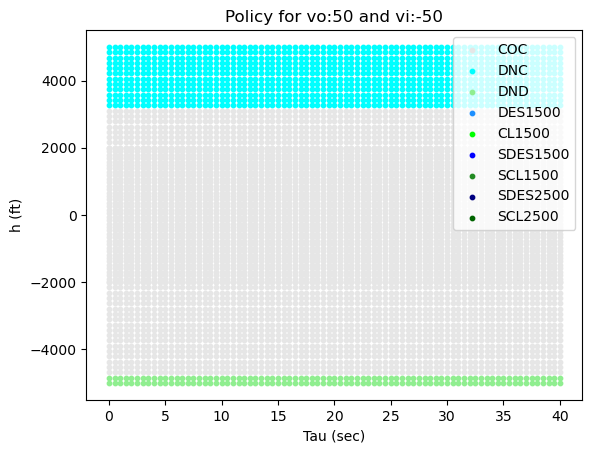

on epoch 4
Policy viz before projectionh loss 2304.82177734375 and accuracy 0.586279988288879486
203/203 [==============================] - 1s 3ms/step


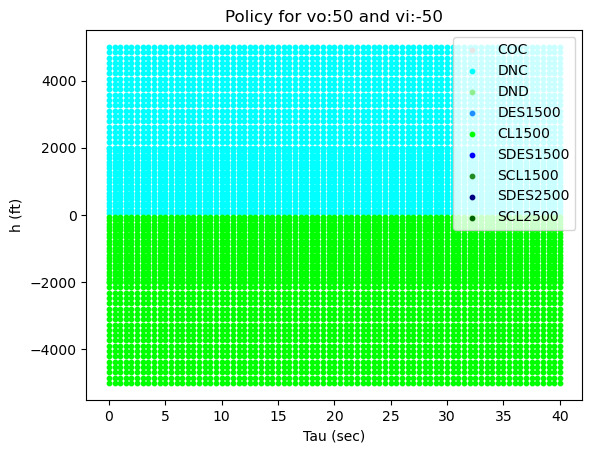

safe region test FAILED, interval was [interval([-1311191.2137062212, -793006.3165996573]), interval([-2026748.8136777964, 2025300.8964082827]), interval([-1628100.2482662161, 1588745.9968413506]), interval([-1951536.4849902627, 2015558.5106863175]), interval([-1644178.8089622331, 1638472.7862473894]), interval([-1539002.60711789, 1474983.240519622]), interval([-1561311.0120704114, 1466210.354407501]), interval([-4631.654063174313, -2838.7087293994227]), interval([-1840565.6966869808, 1790778.7185077455])]

Projecting weights at epoch 4.
After projecting, output interval is [interval([6999.9621024967155, 9877.793296210879]), interval([-2026748.8136777964, 2025300.8964082827]), interval([-1628100.2482662161, 1588745.9968413506]), interval([-1951536.4849902627, 2015558.5106863175]), interval([-1644178.8089622331, 1638472.7862473894]), interval([-1539002.60711789, 1474983.240519622]), interval([-1561311.0120704114, 1466210.354407501]), interval([-1999.999948445331, -1227.5876928921912]), 

/Users/nishant/miniforge3/envs/mlp/lib/python3.10/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


203/203 [==============================] - 1s 3ms/step


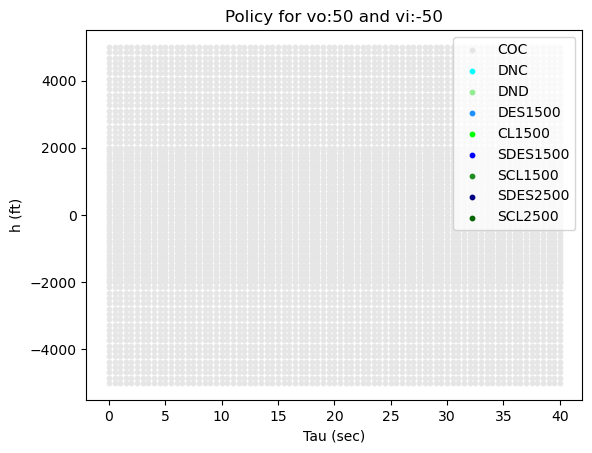

on epoch 5
Policy viz before projectionh loss 163.34071350097656 and accuracy 0.5837200284004211
203/203 [==============================] - 1s 2ms/step


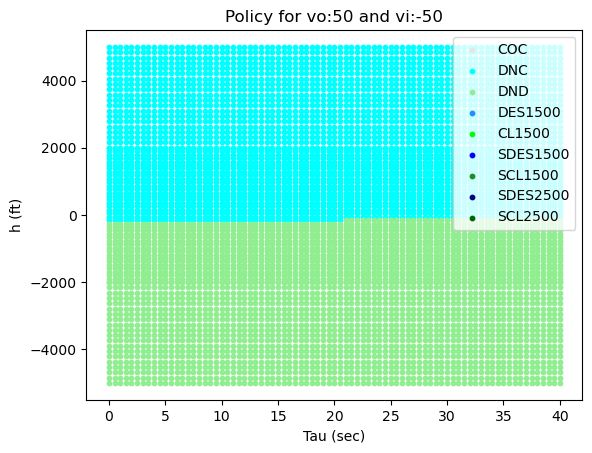

safe region test FAILED, interval was [interval([-1314520.0996937377, -794539.4251178303]), interval([-2111425.7691341825, 2112775.2608784544]), interval([-1696305.136870214, 1658175.4973217628]), interval([-2033431.1840890304, 2099091.3144046785]), interval([-1713817.8289618671, 1708055.9376822617]), interval([-1596835.6894005605, 1545422.0583629226]), interval([-1625461.271175303, 1532614.2322799512]), interval([-4691.0463810890105, -2863.660799545563]), interval([-1912905.0388651127, 1875311.9469610236])]

Projecting weights at epoch 5.
After projecting, output interval is [interval([6999.954053036131, 10005.26112279584]), interval([-2111425.7691341825, 2112775.2608784544]), interval([-1696305.136870214, 1658175.4973217628]), interval([-2033431.1840890304, 2099091.3144046785]), interval([-1713817.8289618671, 1708055.9376822617]), interval([-1596835.6894005605, 1545422.0583629226]), interval([-1625461.271175303, 1532614.2322799512]), interval([-1999.999979927093, -1218.2974083141876]

/Users/nishant/miniforge3/envs/mlp/lib/python3.10/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


203/203 [==============================] - 1s 2ms/step


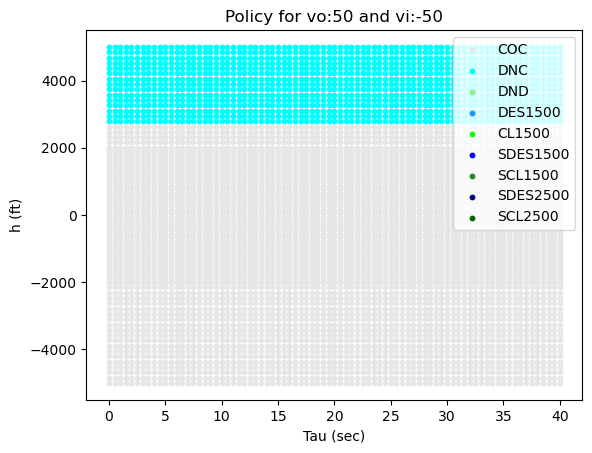

on epoch 6
Policy viz before projectionh loss 127.6349868774414 and accuracy 0.59628999233245851
203/203 [==============================] - 0s 2ms/step


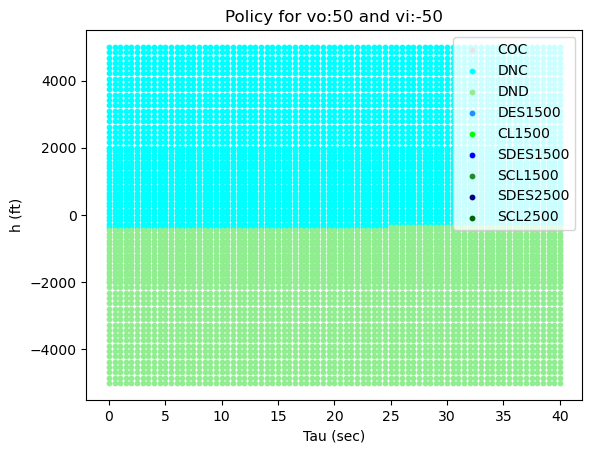

safe region test FAILED, interval was [interval([-1312278.5152417435, -798216.8961654364]), interval([-2163407.5940835075, 2165803.09893788]), interval([-1738035.6243302417, 1700210.5773923679]), interval([-2083550.822105851, 2150471.788708639]), interval([-1757333.755354764, 1749987.7361164591]), interval([-1637190.1022540699, 1584619.409774048]), interval([-1667294.5135603524, 1572288.979242389]), interval([-5554.33929280798, -3402.5867782885794]), interval([-1961433.3144204793, 1923633.0375899125])]

Projecting weights at epoch 6.
After projecting, output interval is [interval([6999.945760441657, 10047.139268415136]), interval([-2163407.5940835075, 2165803.09893788]), interval([-1738035.6243302417, 1700210.5773923679]), interval([-2083550.822105851, 2150471.788708639]), interval([-1757333.755354764, 1749987.7361164591]), interval([-1637190.1022540699, 1584619.409774048]), interval([-1667294.5135603524, 1572288.979242389]), interval([-1999.999903537739, -1216.9210008698083]), interva

/Users/nishant/miniforge3/envs/mlp/lib/python3.10/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


203/203 [==============================] - 0s 2ms/step


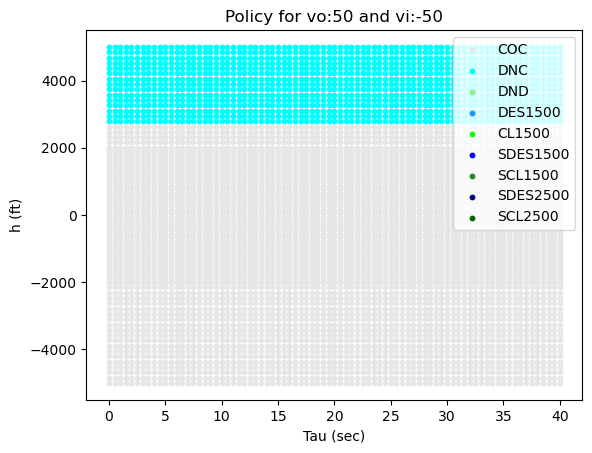

on epoch 7
Policy viz before projectionh loss 41.433780670166016 and accuracy 0.6102799773216248
203/203 [==============================] - 1s 2ms/step


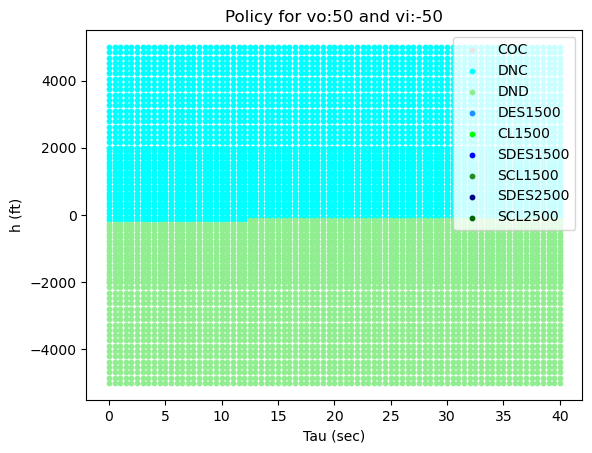

safe region test FAILED, interval was [interval([-1324467.5948799308, -806277.7232474227]), interval([-2199884.1763320835, 2202012.8460156512]), interval([-1766556.1876571823, 1727963.8114634946]), interval([-2115593.5051552635, 2183619.796883505]), interval([-1787278.4977779193, 1778425.6297354829]), interval([-1664210.2555451347, 1610942.9841629553]), interval([-1694751.3594439593, 1599392.1376550552]), interval([-1740.3167331239072, -1047.38821203272]), interval([-1999066.6831125042, 1952658.5950685034])]

Projecting weights at epoch 7.
After projecting, output interval is [interval([6999.93701028529, 10104.834598100717]), interval([-2199884.1763320835, 2202012.8460156512]), interval([-1766556.1876571823, 1727963.8114634946]), interval([-2115593.5051552635, 2183619.796883505]), interval([-1787278.4977779193, 1778425.6297354829]), interval([-1664210.2555451347, 1610942.9841629553]), interval([-1694751.3594439593, 1599392.1376550552]), interval([-1740.3167331239072, -1047.38821203272]

/Users/nishant/miniforge3/envs/mlp/lib/python3.10/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


203/203 [==============================] - 1s 2ms/step


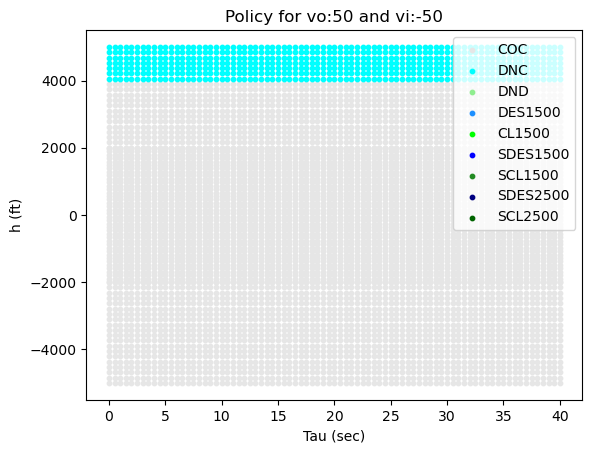

on epoch 8
Policy viz before projectionh loss 242.18389892578125 and accuracy 0.6229100227355957
203/203 [==============================] - 1s 3ms/step


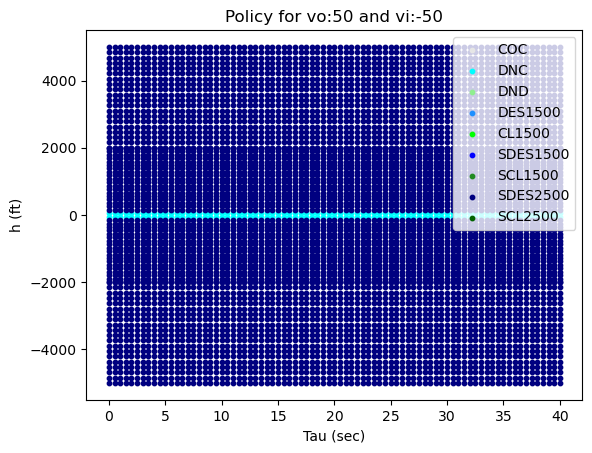

safe region test FAILED, interval was [interval([-1339649.3438425646, -816006.1211201608]), interval([-2290330.5196033097, 2291539.602242551]), interval([-1837528.9668395163, 1798675.1983705098]), interval([-2199725.8011372224, 2271586.455487605]), interval([-1858967.7508804349, 1850590.3790847934]), interval([-1732882.9665128973, 1677455.0967458189]), interval([-1765108.1965877372, 1665641.8526236091]), interval([166.74123839408753, 665.8915949818307]), interval([-2078399.5426295195, 2037248.7906639995])]

Projecting weights at epoch 8.
After projecting, output interval is [interval([6999.9997569757425, 10220.274949541323]), interval([-2290330.5196033097, 2291539.602242551]), interval([-1837528.9668395163, 1798675.1983705098]), interval([-2199725.8011372224, 2271586.455487605]), interval([-1858967.7508804349, 1850590.3790847934]), interval([-1732882.9665128973, 1677455.0967458189]), interval([-1765108.1965877372, 1665641.8526236091]), interval([166.74123839408753, 665.8915949818307]),

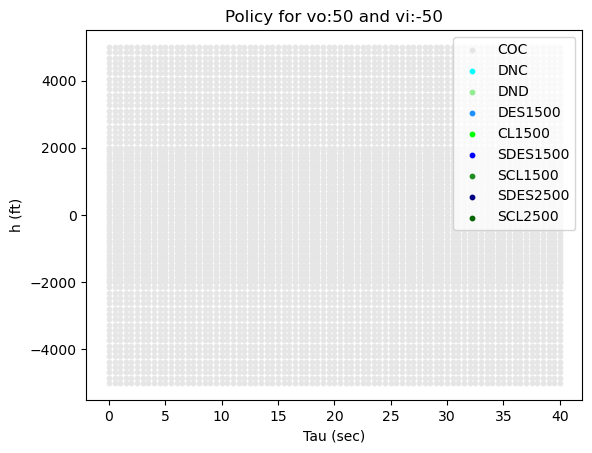

on epoch 9
Policy viz before projectionh loss 260.35748291015625 and accuracy 0.6233999729156494
203/203 [==============================] - 1s 2ms/step


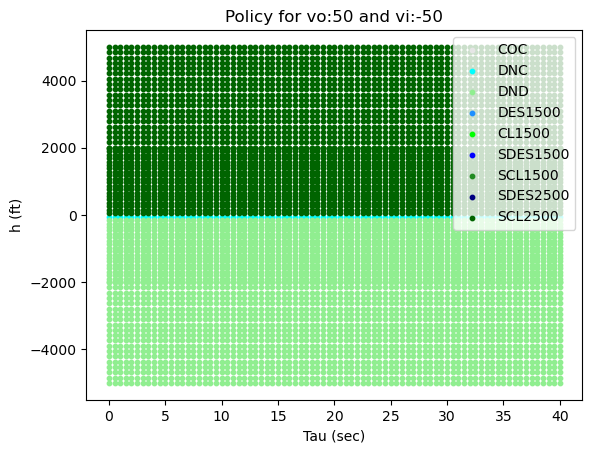

safe region test FAILED, interval was [interval([-1361138.1674716712, -831453.8949549514]), interval([-2338533.6003562743, 2334305.6149606]), interval([-1873471.9722990782, 1834474.3542087646]), interval([-2243353.3480734844, 2315450.406893074]), interval([-1895598.9058170929, 1886252.0244634622]), interval([-1768241.8787575597, 1710746.5422266352]), interval([-1811123.684756193, 1690442.04063188]), interval([-5929.532920428722, -3638.2522919687467]), interval([-2121441.438046776, 2078376.805664339])]

Projecting weights at epoch 9.
After projecting, output interval is [interval([6999.993540224414, 10256.69434180654]), interval([-2338533.6003562743, 2334305.6149606]), interval([-1873471.9722990782, 1834474.3542087646]), interval([-2243353.3480734844, 2315450.406893074]), interval([-1895598.9058170929, 1886252.0244634622]), interval([-1768241.8787575597, 1710746.5422266352]), interval([-1811123.684756193, 1690442.04063188]), interval([-1999.9999409389002, -1212.8505083930795]), interval

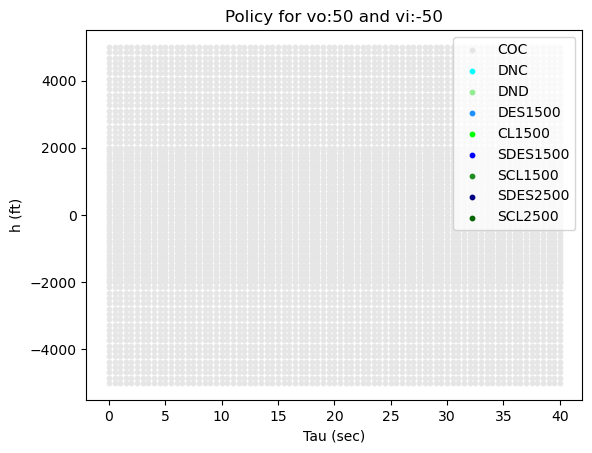

on epoch 10
Policy viz before projectionh loss 257.1116638183594 and accuracy 0.65628999471664435
203/203 [==============================] - 1s 2ms/step


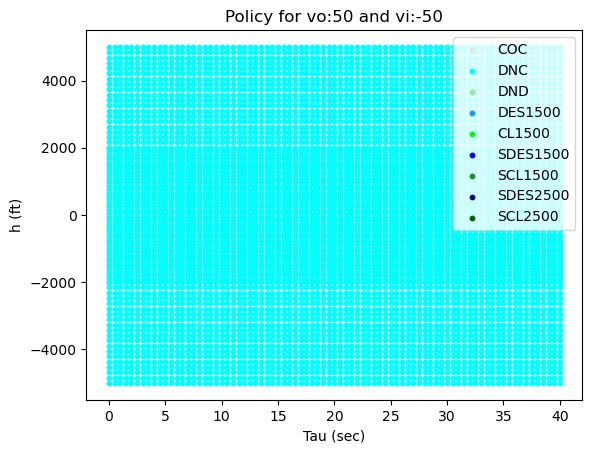

safe region test FAILED, interval was [interval([-1378707.4439929728, -845495.0532766976]), interval([-2392789.669963846, 2392457.350233648]), interval([-1917689.531927691, 1879293.167522782]), interval([-2296259.1304151015, 2369838.360551755]), interval([-1941981.482672288, 1930128.3596752249]), interval([-1811397.9923227686, 1753301.4167148217]), interval([-1848620.501498748, 1740322.0956649284]), interval([-5953.846956074641, -3660.1794309275892]), interval([-2175894.041906781, 2127763.847524958])]

Projecting weights at epoch 10.
After projecting, output interval is [interval([6999.9866233915645, 10292.334952253814]), interval([-2392789.669963846, 2392457.350233648]), interval([-1917689.531927691, 1879293.167522782]), interval([-2296259.1304151015, 2369838.360551755]), interval([-1941981.482672288, 1930128.3596752249]), interval([-1811397.9923227686, 1753301.4167148217]), interval([-1848620.501498748, 1740322.0956649284]), interval([-1999.9999658172699, -1212.2317426136233]), inter

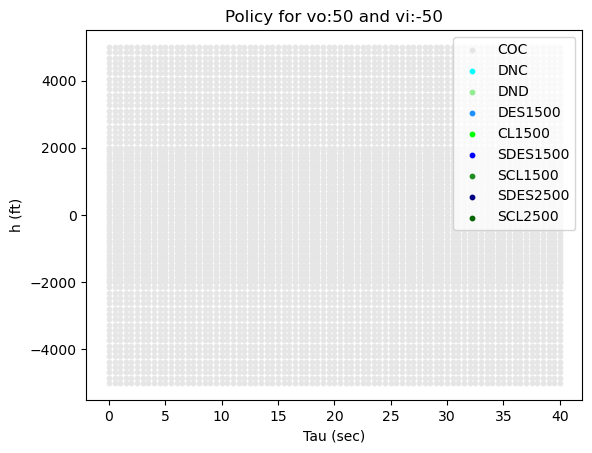

on epoch 11
Policy viz before projectionh loss 145.1627960205078 and accuracy 0.63804000616073616
203/203 [==============================] - 1s 3ms/step


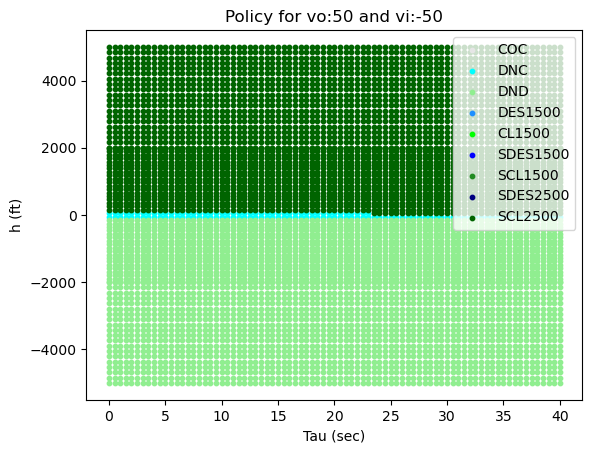

safe region test FAILED, interval was [interval([-1390088.284233489, -847244.880663594]), interval([-2401074.9784552064, 2399316.0852254527]), interval([-1924027.7530935716, 1885482.2258258974]), interval([-2302616.8741755704, 2374774.0290612616]), interval([-1949071.3234236178, 1936503.3167725354]), interval([-1817852.1629266734, 1757948.0972209289]), interval([-1853521.5198908239, 1749127.1396563922]), interval([-3647.466375823723, -2215.9994993938963]), interval([-2181240.8557990165, 2137606.749577425])]

Projecting weights at epoch 11.
After projecting, output interval is [interval([6999.978405936758, 10330.768152968049]), interval([-2401074.9784552064, 2399316.0852254527]), interval([-1924027.7530935716, 1885482.2258258974]), interval([-2302616.8741755704, 2374774.0290612616]), interval([-1949071.3234236178, 1936503.3167725354]), interval([-1817852.1629266734, 1757948.0972209289]), interval([-1853521.5198908239, 1749127.1396563922]), interval([-1999.9999972229673, -1202.6120320720

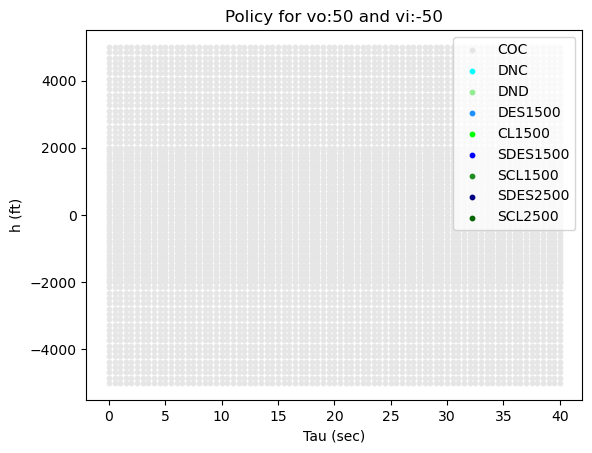

on epoch 12
Policy viz before projectionh loss 79.26026153564453 and accuracy 0.64823997020721444
203/203 [==============================] - 0s 2ms/step


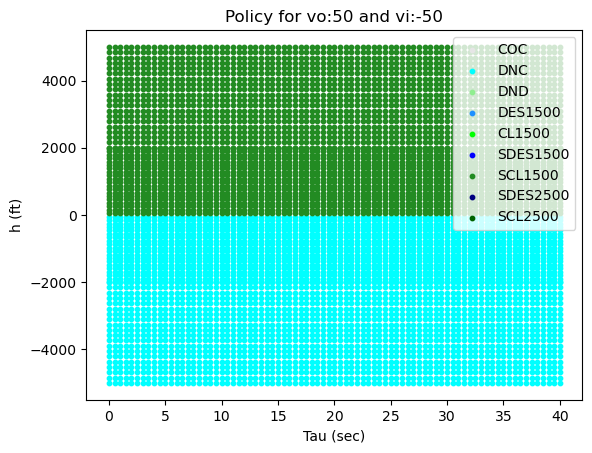

safe region test FAILED, interval was [interval([-1393745.898377805, -852434.5535994498]), interval([-2443236.0995139927, 2442792.482215163]), interval([-1957945.9479384585, 1918280.1660830437]), interval([-2341518.259560152, 2417303.00760335]), interval([-1984223.263280534, 1970332.8479535268]), interval([-1848902.635625812, 1790701.4370585606]), interval([-1887018.6414153816, 1782627.168185806]), interval([-4921.395770214861, -3005.255408264459]), interval([-2221015.725102228, 2177035.4306536373])]

Projecting weights at epoch 12.
After projecting, output interval is [interval([6999.9705763583, 10383.983363643998]), interval([-2443236.0995139927, 2442792.482215163]), interval([-1957945.9479384585, 1918280.1660830437]), interval([-2341518.259560152, 2417303.00760335]), interval([-1984223.263280534, 1970332.8479535268]), interval([-1848902.635625812, 1790701.4370585606]), interval([-1887018.6414153816, 1782627.168185806]), interval([-1999.999973301089, -1203.1405787487156]), interval([

/Users/nishant/miniforge3/envs/mlp/lib/python3.10/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


203/203 [==============================] - 0s 2ms/step


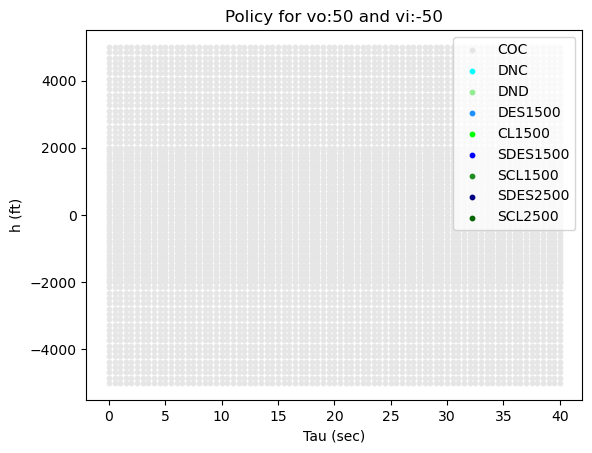

on epoch 13
Policy viz before projectionh loss 47.7305793762207 and accuracy 0.675610005855560334
203/203 [==============================] - 0s 2ms/step


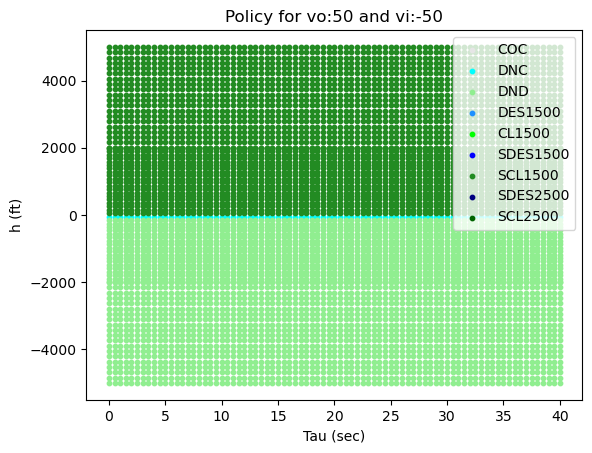

safe region test FAILED, interval was [interval([-1404663.8109263354, -858040.6795625678]), interval([-2475905.6934449035, 2475456.5004818896]), interval([-1984491.0816127947, 1944369.3803563705]), interval([-2373629.435242553, 2450126.980304936]), interval([-2010422.9392533852, 1995815.2004272714]), interval([-1874111.161521923, 1815719.3074722877]), interval([-1914425.65397418, 1808563.5594352516]), interval([-5903.91639208355, -3600.6620280579996]), interval([-2251803.8061394836, 2207084.2927463017])]

Projecting weights at epoch 13.
After projecting, output interval is [interval([6999.962527509277, 10431.105273321888]), interval([-2475905.6934449035, 2475456.5004818896]), interval([-1984491.0816127947, 1944369.3803563705]), interval([-2373629.435242553, 2450126.980304936]), interval([-2010422.9392533852, 1995815.2004272714]), interval([-1874111.161521923, 1815719.3074722877]), interval([-1914425.65397418, 1808563.5594352516]), interval([-1999.999954014811, -1197.503143556618]), int

/Users/nishant/miniforge3/envs/mlp/lib/python3.10/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


203/203 [==============================] - 0s 2ms/step


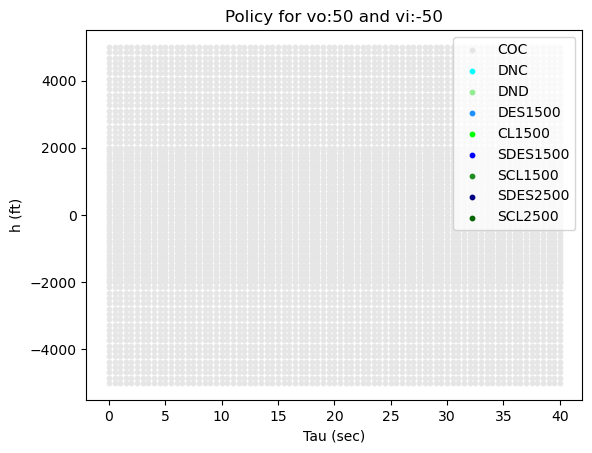

on epoch 14
Policy viz before projectionh loss 105.12091064453125 and accuracy 0.6779699921607971
203/203 [==============================] - 0s 2ms/step


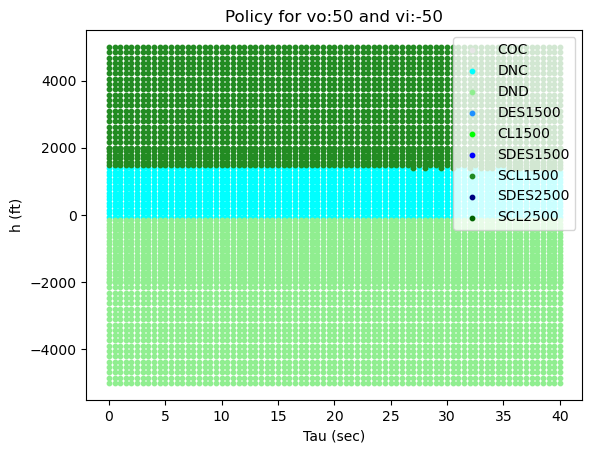

safe region test FAILED, interval was [interval([-1404070.9698534347, -850626.1518270317]), interval([-2438561.768523303, 2437300.41376159]), interval([-1954640.756106433, 1914224.151479674]), interval([-2335395.1956224535, 2411582.169681826]), interval([-1979696.352927573, 1966422.2514804145]), interval([-1845874.1157012715, 1788902.670414837]), interval([-1887941.4102904615, 1780124.6236636215]), interval([-6353.93455171939, -3844.8613667602435]), interval([-2223485.6696318807, 2168833.4383774875])]

Projecting weights at epoch 14.
After projecting, output interval is [interval([6999.952681195549, 10429.478030352318]), interval([-2438561.768523303, 2437300.41376159]), interval([-1954640.756106433, 1914224.151479674]), interval([-2335395.1956224535, 2411582.169681826]), interval([-1979696.352927573, 1966422.2514804145]), interval([-1845874.1157012715, 1788902.670414837]), interval([-1887941.4102904615, 1780124.6236636215]), interval([-1999.9998218499315, -1184.5099974690397]), interva

/Users/nishant/miniforge3/envs/mlp/lib/python3.10/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


203/203 [==============================] - 0s 2ms/step


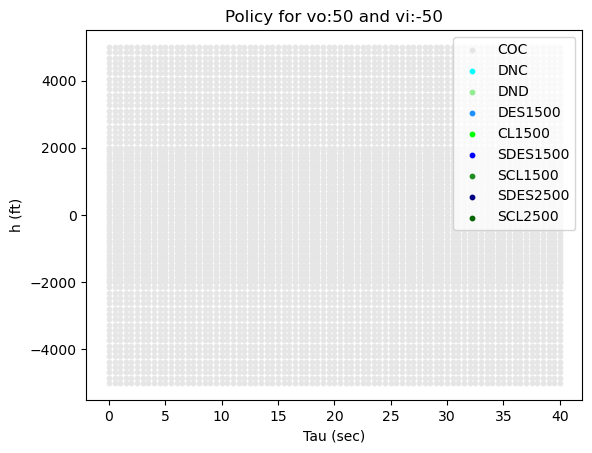

on epoch 15
Policy viz before projectionh loss 236.04185485839844 and accuracy 0.6823800206184387
203/203 [==============================] - 0s 2ms/step


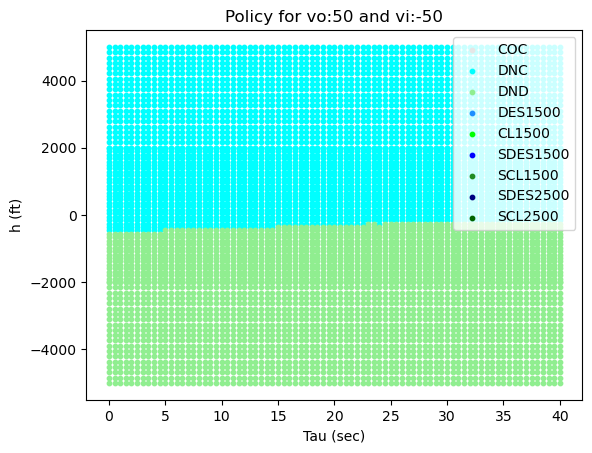

safe region test FAILED, interval was [interval([-1411545.5431039142, -850481.6924454035]), interval([-2474774.774098887, 2473280.132380231]), interval([-1984005.8379018551, 1941831.5244223727]), interval([-2368732.0005091447, 2445656.61071254]), interval([-2007418.119491741, 1993404.4291843572]), interval([-1873770.0840827292, 1815322.6925032106]), interval([-1924418.0998006181, 1799493.5858532933]), interval([-5105.714057641628, -3064.100147917449]), interval([-2252348.7213139497, 2205097.428069771])]

Projecting weights at epoch 15.
After projecting, output interval is [interval([6999.945323304776, 10504.199122997612]), interval([-2474774.774098887, 2473280.132380231]), interval([-1984005.8379018551, 1941831.5244223727]), interval([-2368732.0005091447, 2445656.61071254]), interval([-2007418.119491741, 1993404.4291843572]), interval([-1873770.0840827292, 1815322.6925032106]), interval([-1924418.0998006181, 1799493.5858532933]), interval([-1999.9998688749808, -1177.1023239340432]), in

/Users/nishant/miniforge3/envs/mlp/lib/python3.10/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


203/203 [==============================] - 0s 2ms/step


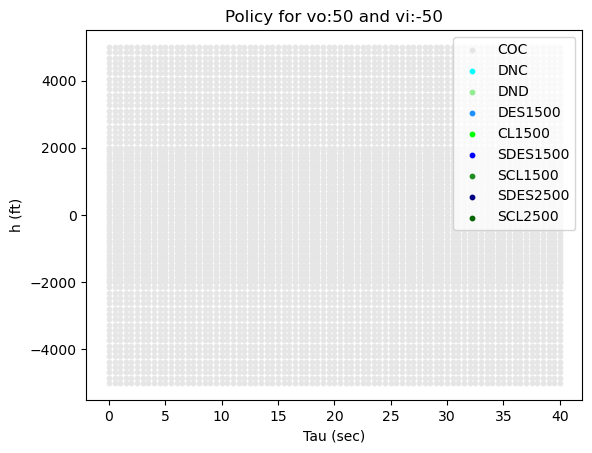

on epoch 16
Policy viz before projectionh loss 769.3568725585938 and accuracy 0.68162000179290777
203/203 [==============================] - 0s 2ms/step


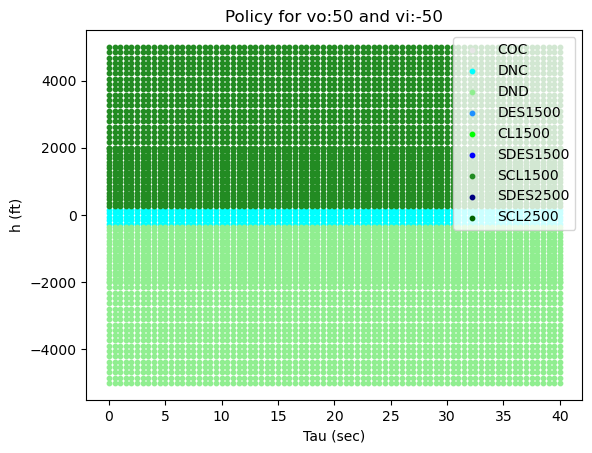

safe region test FAILED, interval was [interval([-1426714.0642768713, -860046.9610030077]), interval([-2506476.8053056365, 2505521.6149842003]), interval([-2008901.482681697, 1966714.86146796]), interval([-2398652.0305370227, 2476685.1125527387]), interval([-2032700.9151469267, 2018217.8557433505]), interval([-1899398.305018775, 1838173.6353960067]), interval([-1942650.9689040575, 1832421.787947932]), interval([-6191.292568212407, -3724.4508471243594]), interval([-2284728.3580688904, 2230903.7389547722])]

Projecting weights at epoch 16.
After projecting, output interval is [interval([6999.93799764215, 10546.007745953775]), interval([-2506476.8053056365, 2505521.6149842003]), interval([-2008901.482681697, 1966714.86146796]), interval([-2398652.0305370227, 2476685.1125527387]), interval([-2032700.9151469267, 2018217.8557433505]), interval([-1899398.305018775, 1838173.6353960067]), interval([-1942650.9689040575, 1832421.787947932]), interval([-1999.9998429989942, -1176.2680371049719]), i

/Users/nishant/miniforge3/envs/mlp/lib/python3.10/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


203/203 [==============================] - 0s 2ms/step


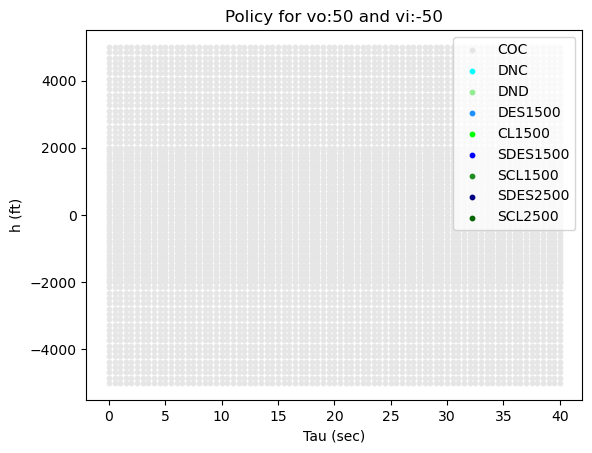

on epoch 17
Policy viz before projectionh loss 199.0879669189453 and accuracy 0.66939002275466921
203/203 [==============================] - 0s 2ms/step


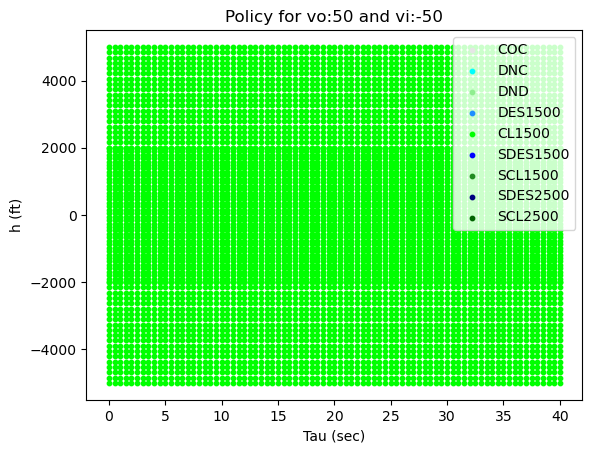

safe region test FAILED, interval was [interval([-1431669.3492591945, -863296.3621456448]), interval([-2536862.180761352, 2521177.813925538]), interval([-2028669.6698456034, 1981875.2489697766]), interval([-2420744.563200969, 2487044.7424693517]), interval([-2023950.2679078495, 2052491.3416337797]), interval([-1911711.9095426246, 1859344.9626175743]), interval([-1955019.4439366418, 1852491.9981661567]), interval([-1550.5037950604046, -74.15612637768666]), interval([-2295237.2145852027, 2253960.1239109985])]

Projecting weights at epoch 17.
After projecting, output interval is [interval([6999.9311873151355, 11176.670861850975]), interval([-2536862.180761352, 2521177.813925538]), interval([-2028669.6698456034, 1981875.2489697766]), interval([-2420744.563200969, 2487044.7424693517]), interval([-2023950.2679078495, 2052491.3416337797]), interval([-1911711.9095426246, 1859344.9626175743]), interval([-1955019.4439366418, 1852491.9981661567]), interval([-1550.5037950604046, -74.15612637768666

/Users/nishant/miniforge3/envs/mlp/lib/python3.10/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


203/203 [==============================] - 0s 2ms/step


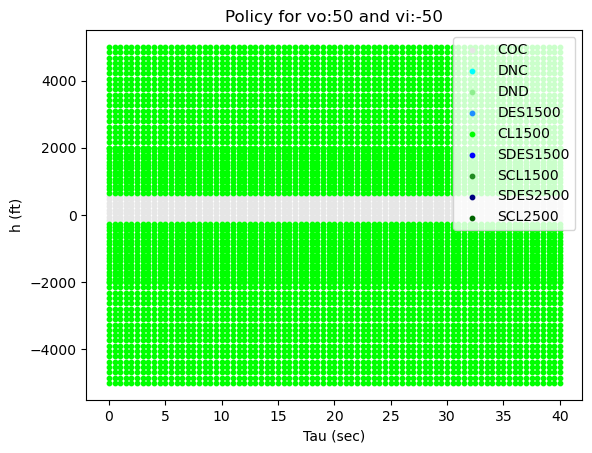

on epoch 18
Policy viz before projectionh loss 57.710548400878906 and accuracy 0.6721100211143494
203/203 [==============================] - 0s 2ms/step


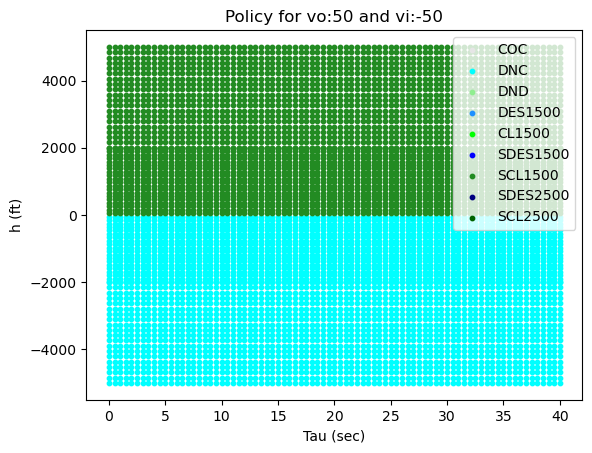

safe region test FAILED, interval was [interval([-1425800.8267249265, -851779.8526339324]), interval([-2524660.81913238, 2520553.37616093]), interval([-2023720.2410104503, 1977082.1167958018]), interval([-2412791.4526804807, 2479815.3148817993]), interval([-2031118.4391077566, 2030196.4381053215]), interval([-1907014.678018008, 1854671.5378827422]), interval([-1950656.7947595473, 1848442.876978701]), interval([-4278.128078109366, -2186.2784844107036]), interval([-2284805.224751053, 2252121.8992023286])]

Projecting weights at epoch 18.
After projecting, output interval is [interval([6999.999846250939, 11216.526380833599]), interval([-2524660.81913238, 2520553.37616093]), interval([-2023720.2410104503, 1977082.1167958018]), interval([-2412791.4526804807, 2479815.3148817993]), interval([-2031118.4391077566, 2030196.4381053215]), interval([-1907014.678018008, 1854671.5378827422]), interval([-1950656.7947595473, 1848442.876978701]), interval([-1999.9998570384519, -820.8026660710352]), inte

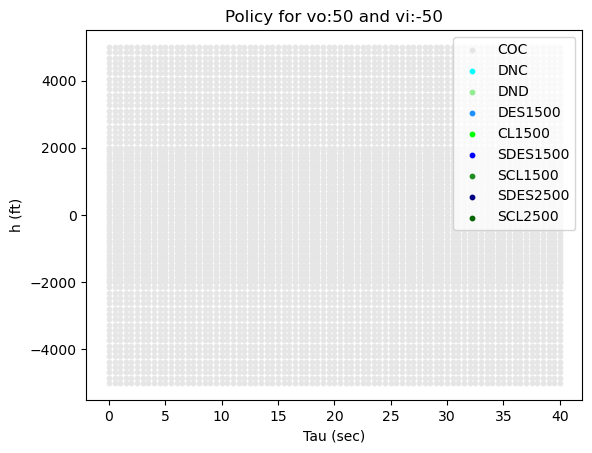

on epoch 19
Policy viz before projectionh loss 600.3639526367188 and accuracy 0.67805999517440823
203/203 [==============================] - 0s 2ms/step


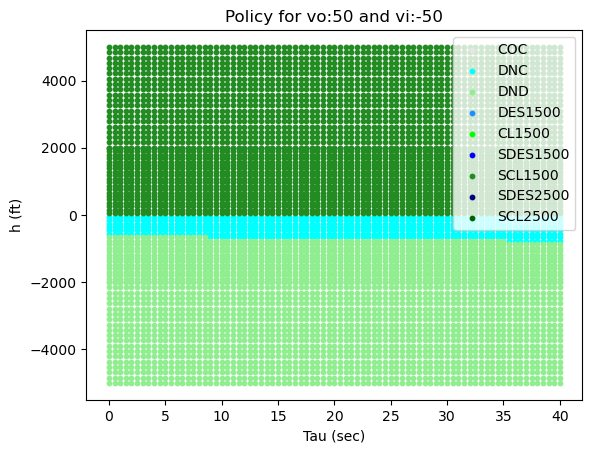

safe region test FAILED, interval was [interval([-1431254.432529034, -858491.2937564924]), interval([-2562312.4100779574, 2557966.06993911]), interval([-2053935.6720086844, 2007573.0003352258]), interval([-2450139.8288095575, 2517552.8439227864]), interval([-2061626.3236378224, 2059997.4216666156]), interval([-1935895.401542792, 1882587.2883181723]), interval([-1983014.4904858742, 1879217.401917538]), interval([-7178.569865586292, -3950.0683838452055]), interval([-2328177.5941167446, 2280135.392673361])]

Projecting weights at epoch 19.
After projecting, output interval is [interval([6999.992186755185, 11229.651978933549]), interval([-2562312.4100779574, 2557966.06993911]), interval([-2053935.6720086844, 2007573.0003352258]), interval([-2450139.8288095575, 2517552.8439227864]), interval([-2061626.3236378224, 2059997.4216666156]), interval([-1935895.401542792, 1882587.2883181723]), interval([-1983014.4904858742, 1879217.401917538]), interval([-1999.9999352278185, -819.0848728965876]), i

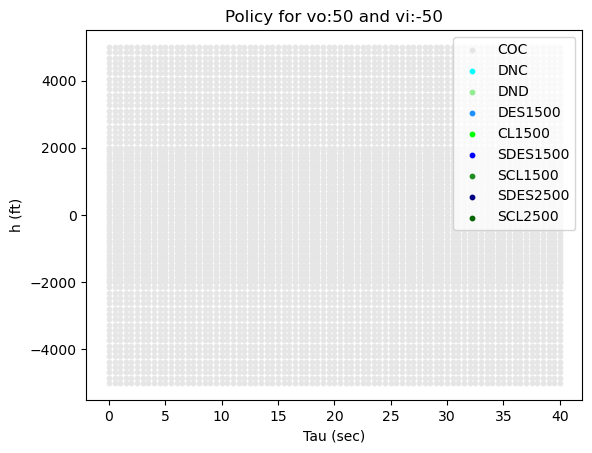

In [42]:
epoch_losses = []
epoch_accuracies = []
weights_before_projection = []
weights_after_projection = []
for epoch in range(totalEpochs):
    print(f"on epoch {epoch}")

    rng = np.random.default_rng()

    train_indices = np.arange(X_train.shape[0])

    rng.shuffle(train_indices)  # in-place

    x_shuffled = X_train[train_indices, :]
    y_shuffled = Q[train_indices, :]

    x_batched = np.split(
        x_shuffled, np.arange(BATCH_SIZE, len(x_shuffled), BATCH_SIZE)
    )
    y_batched = np.split(
        y_shuffled, np.arange(BATCH_SIZE, len(y_shuffled), BATCH_SIZE)
    )

    dataset_batched = list(zip(x_batched, y_batched))
    batch_losses = []
    batch_accuracy_list = []
    epoch_accuracy = keras.metrics.CategoricalAccuracy()
    for step, (x_batch_train, y_batch_train) in enumerate(dataset_batched):
        with tf.GradientTape() as tape:
            y_pred = model(x_batch_train, training=True)  # Forward pass
            loss = asymMSE(y_batch_train, y_pred)
            epoch_accuracy.update_state(y_batch_train, y_pred)

            # accumulate data
            batch_losses.append(loss.numpy())
            batch_accuracy_list.append(epoch_accuracy.result())
        if step % int(num_batches / 500) == 0:
            print(
                f"{np.round(step / num_batches * 100, 1)}% through this epoch with loss",
                f"{np.round(loss.numpy(), 5)} and accuracy {np.round(epoch_accuracy.result(), 5)}\r",
                end="",
            )
        # Compute gradients
        trainable_vars = model.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        opt.apply_gradients(zip(gradients, trainable_vars))

    epoch_accuracies.append(batch_accuracy_list)
    epoch_losses.append(batch_losses)

    weights_before_projection.append([w.numpy() for w in model.layers[-1].weights])
    print("Policy viz before projection")
    plot_policy(model, f"pre_projection_policy_viz_vo50_vi-50_epoch{epoch}.pdf")

    # Parameters:
    # - h (ft): Altitude of intruder relative to ownship, [-8000, 8000]
    # - vO (ft/s): ownship vertical climb rate, [-100, 100]
    # - vI (ft/s): intruder vertical climb rate, [-100, 100]
    # - τ (sec): time to loss of horizontal separation
    output_interval, penultimate_interval = propagate_interval(
        COC_INTERVAL,
        model,
        graph=False,
    )
    if not check_intervals(output_interval, desired_interval):
        print(f"safe region test FAILED, interval was {output_interval}")
        if epoch % EPOCH_TO_PROJECT == 0:
            print(f"\nProjecting weights at epoch {epoch}.")
            intervals_to_project = []
            assert type(output_interval) == type(desired_interval)
            if type(output_interval) is list:
                assert len(output_interval) == len(desired_interval)
                for i in range(len(output_interval)):
                    if (
                        desired_interval[i] is not None
                        and output_interval[i] not in desired_interval[i]
                    ):
                        intervals_to_project.append(i)
            else:
                intervals_to_project.append(0)

            weights_tf = model.layers[-1].weights
            weights_np = weights_tf[0].numpy()
            biases_np = weights_tf[1].numpy()

            for idx in intervals_to_project:
                weights_to_project = np.hstack([weights_np[:, idx], biases_np[idx]])
                proj = project_weights(
                    desired_interval[idx], penultimate_interval, weights_to_project
                )
                weights_np[:, idx] = proj[:-1]
                biases_np[idx] = proj[-1]

            model.layers[-1].set_weights([weights_np, biases_np])
            output_interval, _ = propagate_interval(
                COC_INTERVAL,
                model,
                graph=False,
            )
            print(f"After projecting, output interval is {output_interval}")
            weights_after_projection.append(
                [w.numpy() for w in model.layers[-1].weights]
            )
            print("Policy viz after projection")
            plot_policy(model, f"post_projection_policy_viz_vo50_vi-50_epoch{epoch}.pdf")
    else:
        print(f"safe region test passed, interval was {output_interval}")

    # Logging outputs
    with open("projection_acas_july6_coc_new_plots.pickle", "wb") as f:
        data = {
            "accuracies": epoch_accuracies,
            "losses": epoch_losses,
            "weights_before_projection": weights_before_projection,
            "weights_after_projection": weights_after_projection,
        }
        pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)
